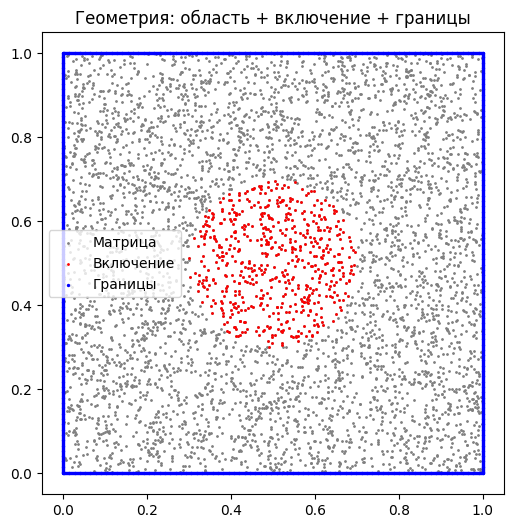

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
N_domain = 5000      # Точек внутри области
N_boundary = 500     # Точек на границах
radius = 0.2
inclusion_center = torch.tensor([0.5, 0.5])

def is_in_inclusion(xy, center, radius):
    return torch.norm(xy - center, dim=1) < radius


# Точки внутри области
domain_xy = torch.rand((N_domain, 2), dtype=torch.float32)

# Точки на границах (x=0, x=1, y=0, y=1)
x_vals = torch.linspace(0, 1, N_boundary)
y_vals = torch.linspace(0, 1, N_boundary)

# Левая и правая грани (x=0 и x=1)
left_boundary = torch.stack([torch.zeros(N_boundary), y_vals], dim=1)
right_boundary = torch.stack([torch.ones(N_boundary), y_vals], dim=1)

# Нижняя и верхняя грани (y=0 и y=1)
bottom_boundary = torch.stack([x_vals, torch.zeros(N_boundary)], dim=1)
top_boundary = torch.stack([x_vals, torch.ones(N_boundary)], dim=1)

boundary_xy = torch.cat([left_boundary, right_boundary, bottom_boundary, top_boundary], dim=0)

# Маска включения (для области)
inclusion_mask = is_in_inclusion(domain_xy, inclusion_center, radius)

# Визуализация
plt.figure(figsize=(6,6))
plt.scatter(domain_xy[:,0], domain_xy[:,1], s=1, c='gray', label="Матрица")
plt.scatter(domain_xy[inclusion_mask][:,0], domain_xy[inclusion_mask][:,1], s=1, c='red', label="Включение")
plt.scatter(boundary_xy[:,0], boundary_xy[:,1], s=2, c='blue', label="Границы")
plt.legend()
plt.title("Геометрия: область + включение + границы")
plt.gca().set_aspect('equal')
plt.show()



In [12]:
class PINN(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, hidden_layers=6, neurons=128):  # Увеличим сеть
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_dim, neurons))
        layers.append(nn.Tanh())
        
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(neurons, out_dim))
        self.model = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        return self.model(x)

    def _initialize_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [13]:
def compute_strain(u, x):
    # u: (N, 2), x: (N, 2)
    u_x = u[:, 0:1]
    u_y = u[:, 1:2]

    grads = torch.ones_like(u_x)

    dux_dx = torch.autograd.grad(u_x, x, grads, create_graph=True)[0][:, 0:1]
    dux_dy = torch.autograd.grad(u_x, x, grads, create_graph=True)[0][:, 1:2]
    duy_dx = torch.autograd.grad(u_y, x, grads, create_graph=True)[0][:, 0:1]
    duy_dy = torch.autograd.grad(u_y, x, grads, create_graph=True)[0][:, 1:2]

    eps_xx = dux_dx
    eps_yy = duy_dy
    eps_xy = 0.5 * (dux_dy + duy_dx)

    return eps_xx, eps_yy, eps_xy

In [14]:
def compute_stress(eps_xx, eps_yy, eps_xy, E, nu):
    # Закон Гука 
    coef = E / (1 - nu**2)

    sigma_xx = coef * (eps_xx + nu * eps_yy)
    sigma_yy = coef * (eps_yy + nu * eps_xx)
    sigma_xy = coef * (1 - nu) * eps_xy

    return sigma_xx, sigma_yy, sigma_xy

In [15]:
def compute_pde_residual(x, model, E_mat, nu_mat, E_inc, nu_inc, inclusion_mask):
    x.requires_grad_(True)

    u = model(x)  # (N, 2)
    eps_xx, eps_yy, eps_xy = compute_strain(u, x)

    # Разные свойства для матрицы и включения
    E = torch.where(inclusion_mask, E_inc, E_mat)
    nu = torch.where(inclusion_mask, nu_inc, nu_mat)

    sigma_xx, sigma_yy, sigma_xy = compute_stress(eps_xx, eps_yy, eps_xy, E, nu)

    grads = torch.ones_like(sigma_xx)

    dsigmaxx_dx = torch.autograd.grad(sigma_xx, x, grads, create_graph=True)[0][:, 0:1]
    dsigmaxy_dy = torch.autograd.grad(sigma_xy, x, grads, create_graph=True)[0][:, 1:2]
    dsigmayy_dy = torch.autograd.grad(sigma_yy, x, grads, create_graph=True)[0][:, 1:2]
    dsigmaxy_dx = torch.autograd.grad(sigma_xy, x, grads, create_graph=True)[0][:, 0:1]

    r1 = dsigmaxx_dx + dsigmaxy_dy  # Уравнение равновесия по x
    r2 = dsigmayy_dy + dsigmaxy_dx  # Уравнение равновесия по y

    return r1, r2

In [16]:
delta = 0.05
def loss_pde(model, x_domain, E_mat, nu_mat, E_inc, nu_inc, inclusion_mask):
    r1, r2 = compute_pde_residual(x_domain, model, E_mat, nu_mat, E_inc, nu_inc, inclusion_mask)
    return F.mse_loss(r1, torch.zeros_like(r1)) + F.mse_loss(r2, torch.zeros_like(r2))

def loss_bc(model, left, right, bottom, top, delta=0.01):
    # Левая граница: закрепление (u=0)
    u_left = model(left)
    loss_left = F.mse_loss(u_left, torch.zeros_like(u_left))
    
    # Правая граница: смещение ux = delta
    u_right_pred = model(right)
    ux_target = torch.full_like(u_right_pred[:, 0:1], delta)
    uy_target = torch.zeros_like(u_right_pred[:, 1:2])
    target_right = torch.cat([ux_target, uy_target], dim=1)
    loss_right = F.mse_loss(u_right_pred, target_right)
    
    # Нижняя граница: симметрия (uy=0)
    u_bottom = model(bottom)
    uy_bottom = u_bottom[:, 1:2]
    loss_bottom = F.mse_loss(uy_bottom, torch.zeros_like(uy_bottom))
    
    # Верхняя граница: свободная поверхность (σ_yy=0, σ_xy=0)
    top.requires_grad_(True)
    u_top = model(top)
    eps_xx_t, eps_yy_t, eps_xy_t = compute_strain(u_top, top)
    sigma_xx_t, sigma_yy_t, sigma_xy_t = compute_stress(eps_xx_t, eps_yy_t, eps_xy_t, 
                                                       E_mat, nu_mat)  # Только матрица!
    loss_top_yy = F.mse_loss(sigma_yy_t, torch.zeros_like(sigma_yy_t))
    loss_top_xy = F.mse_loss(sigma_xy_t, torch.zeros_like(sigma_xy_t))
    loss_top = loss_top_yy + loss_top_xy
    
    return loss_left + loss_right + loss_bottom + loss_top

def total_loss(model, x_dom, left, right, bottom, top,
               E_mat, nu_mat, E_inc, nu_inc, mask,
               lambda_pde=1.0, lambda_bc=1.0,delta = 0.01):
    Lpde = loss_pde(model, x_dom, E_mat, nu_mat, E_inc, nu_inc, mask)
    Lbc  = loss_bc(model, left, right, bottom, top, delta)
    total = lambda_pde * Lpde + lambda_bc * Lbc
    return total, {"pde": Lpde.item(), "bc": Lbc.item()}

Using device: cpu
Epoch    1/2000 | Total: 1.62e+06 | PDE: 5.39e+05 | BC: 6.92e-02 | Time: 0.8s
Epoch  400/2000 | Total: 6.06e+00 | PDE: 2.02e+00 | BC: 2.03e-03 | Time: 249.9s
Epoch  800/2000 | Total: 3.38e+00 | PDE: 1.13e+00 | BC: 1.88e-03 | Time: 250.0s
Epoch 1200/2000 | Total: 2.03e+00 | PDE: 6.78e-01 | BC: 1.71e-03 | Time: 252.6s
Epoch 1600/2000 | Total: 1.31e+00 | PDE: 4.37e-01 | BC: 1.54e-03 | Time: 232.0s
Epoch 2000/2000 | Total: 8.29e-01 | PDE: 2.76e-01 | BC: 1.38e-03 | Time: 235.0s


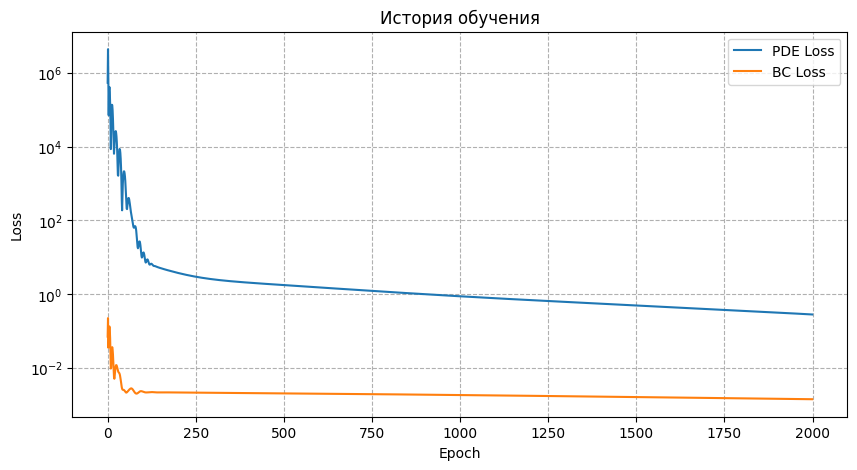

In [17]:
# Параметры материала
E_mat, nu_mat = torch.tensor(1.0), torch.tensor(0.3)   # матрица
E_inc, nu_inc = torch.tensor(10.0), torch.tensor(0.25)  # включение

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Перенос данных на устройство
model = PINN().to(device)
domain_xy = domain_xy.to(device)
inclusion_mask = inclusion_mask.to(device)

left_b = left_boundary.to(device)
right_b = right_boundary.to(device)
bottom_b = bottom_boundary.to(device)
top_b = top_boundary.to(device)

E_mat, nu_mat = E_mat.to(device), nu_mat.to(device)
E_inc, nu_inc = E_inc.to(device), nu_inc.to(device)

# Обучение
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

n_epochs = 2000
print_every = 400
history = []

start_time = time.time()
for epoch in range(1, n_epochs+1):
    optimizer.zero_grad()
    loss, losses = total_loss(
        model,
        domain_xy,
        left_b,
        right_b,
        bottom_b,
        top_b,
        E_mat, nu_mat,
        E_inc, nu_inc,
        inclusion_mask,
        lambda_pde=3.0,
        lambda_bc=0.1,  
        delta = 0.01
    )
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    history.append(losses)
    if epoch % print_every == 0 or epoch == 1:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch:4d}/{n_epochs} | Total: {loss.item():.2e} | PDE: {losses['pde']:.2e} | BC: {losses['bc']:.2e} | Time: {elapsed:.1f}s")
        start_time = time.time()

# Построение кривых обучения
plt.figure(figsize=(10, 5))
plt.semilogy([h['pde'] for h in history], label='PDE Loss')
plt.semilogy([h['bc'] for h in history], label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('История обучения')
plt.grid(True, which="both", ls="--")
plt.show()



Total grid points: 22500 (should be 22500)
eps_xx shape: torch.Size([22500, 1]), expected: (22500, 1)
E shape: torch.Size([22500, 1]), nu shape: torch.Size([22500, 1])
sigma_xx shape: torch.Size([22500, 1])


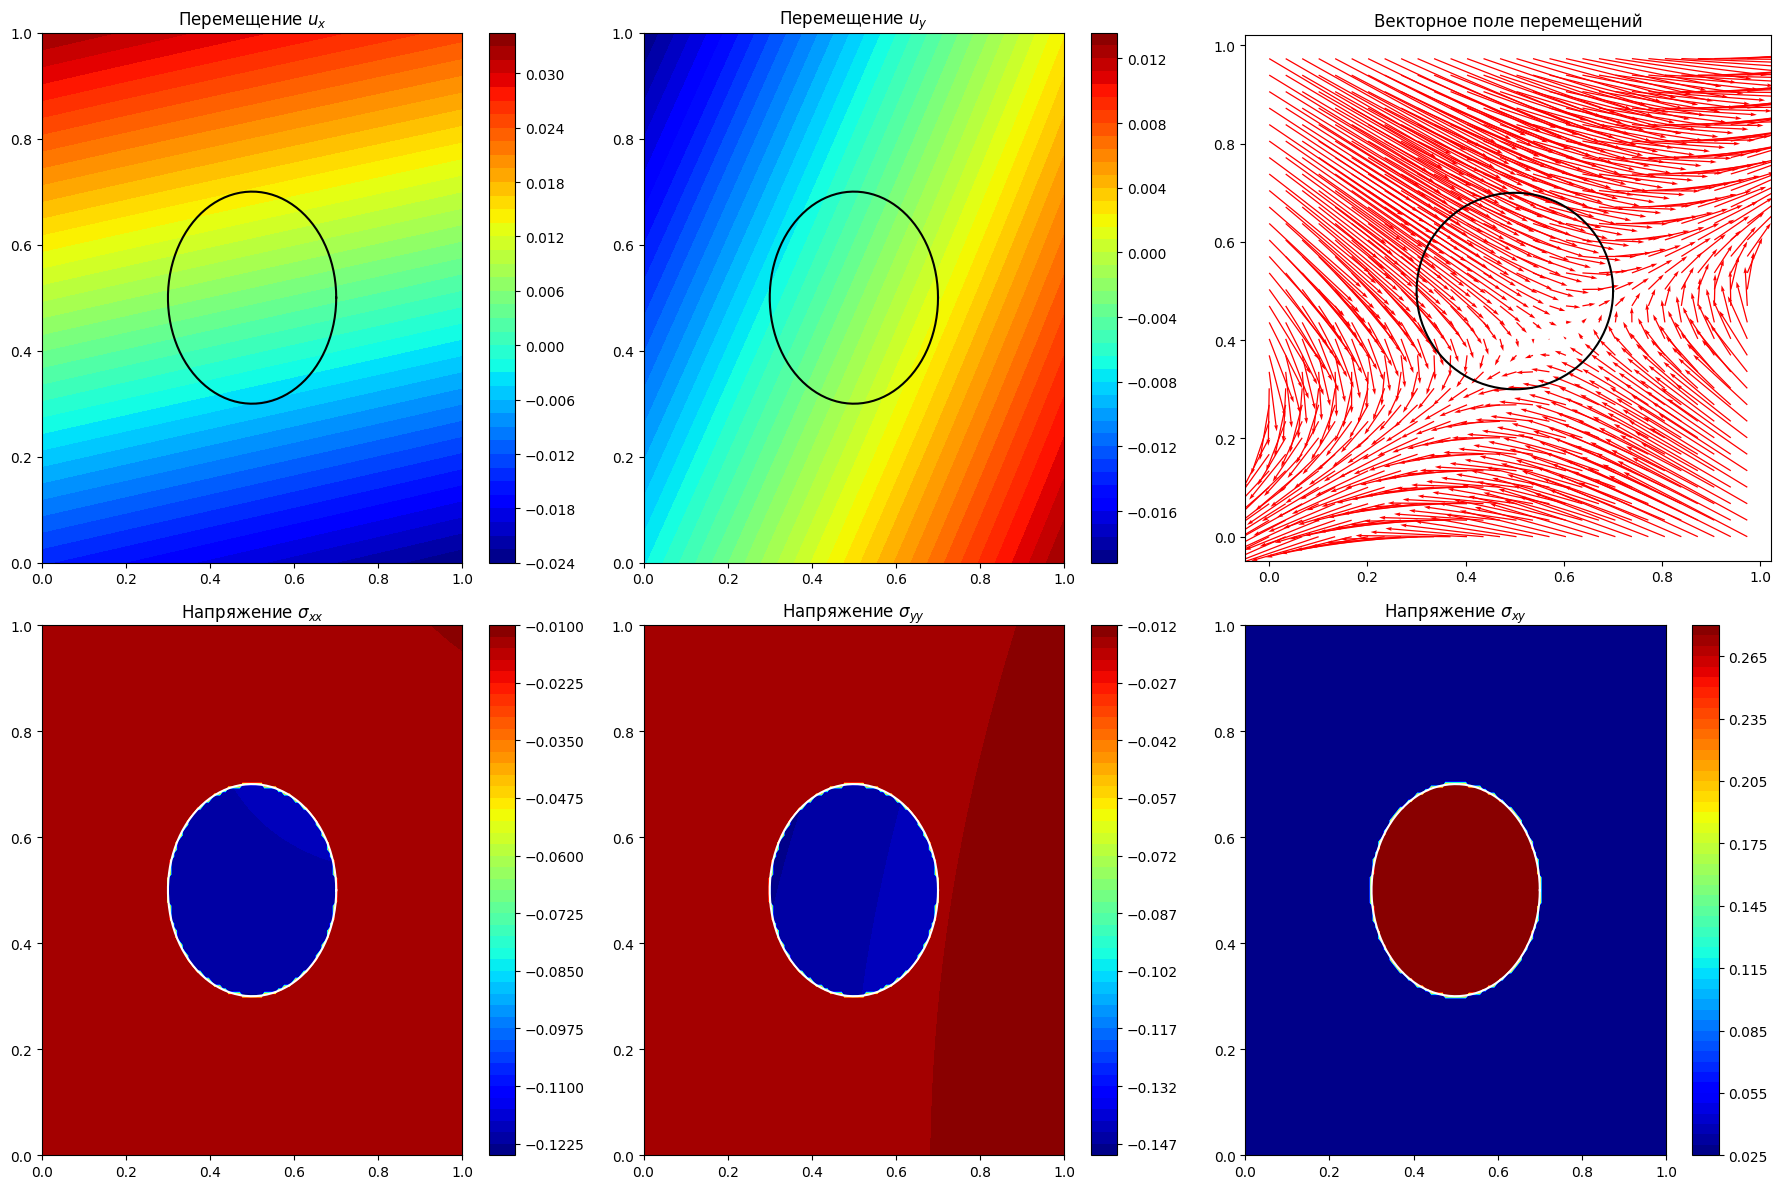

In [18]:
# Визуализация результатов
def plot_results(model, device):
    # Создание расчетной сетки
    nx, ny = 150, 150
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
    total_points = grid_points.shape[0]  
    
    print(f"Total grid points: {total_points} (should be {nx*ny})")
    
    grid = torch.tensor(grid_points, dtype=torch.float32).to(device)
    
    # Маска включения
    inc_mask = is_in_inclusion(grid, inclusion_center.to(device), radius)
    
    # Вычисление перемещений
    with torch.no_grad():
        u_pred = model(grid)
    ux = u_pred[:, 0].cpu().numpy().reshape(nx, ny)
    uy = u_pred[:, 1].cpu().numpy().reshape(nx, ny)
    
    # Вычисление напряжений
    grid.requires_grad_(True)
    u = model(grid)
    eps_xx, eps_yy, eps_xy = compute_strain(u, grid)
    
    # Проверка размерностей
    print(f"eps_xx shape: {eps_xx.shape}, expected: ({total_points}, 1)")
    
    # Используем свойства материала в каждой точке
    E = torch.where(inc_mask, E_inc, E_mat).unsqueeze(1)  
    nu = torch.where(inc_mask, nu_inc, nu_mat).unsqueeze(1) 
    
    # Проверка размерностей
    print(f"E shape: {E.shape}, nu shape: {nu.shape}")
    
    sigma_xx, sigma_yy, sigma_xy = compute_stress(eps_xx, eps_yy, eps_xy, E, nu)
    
    # Проверка размерностей перед преобразованием
    print(f"sigma_xx shape: {sigma_xx.shape}")
    
    # Преобразуем в numpy для визуализации
    S_xx = sigma_xx.detach().cpu().numpy().reshape(nx, ny)
    S_yy = sigma_yy.detach().cpu().numpy().reshape(nx, ny)
    S_xy = sigma_xy.detach().cpu().numpy().reshape(nx, ny)
    
    # Границы включения
    theta = np.linspace(0, 2*np.pi, 100)
    circle_x = inclusion_center[0].item() + radius * np.cos(theta)
    circle_y = inclusion_center[1].item() + radius * np.sin(theta)
    
    # Визуализация
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Перемещения
    im0 = axes[0, 0].contourf(X, Y, ux, cmap='jet', levels=50)
    axes[0, 0].plot(circle_x, circle_y, 'k-', linewidth=1.5)
    axes[0, 0].set_title('Перемещение $u_x$')
    plt.colorbar(im0, ax=axes[0, 0])
    
    im1 = axes[0, 1].contourf(X, Y, uy, cmap='jet', levels=50)
    axes[0, 1].plot(circle_x, circle_y, 'k-', linewidth=1.5)
    axes[0, 1].set_title('Перемещение $u_y$')
    plt.colorbar(im1, ax=axes[0, 1])
    
    # Векторное поле перемещений
    skip = 5
    axes[0, 2].quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                     ux[::skip, ::skip], uy[::skip, ::skip], 
                     scale=0.1, color='r')
    axes[0, 2].plot(circle_x, circle_y, 'k-', linewidth=1.5)
    axes[0, 2].set_title('Векторное поле перемещений')
    axes[0, 2].set_aspect('equal')
    
    # Напряжения (используем raw-строки для LaTeX)
    im2 = axes[1, 0].contourf(X, Y, S_xx, cmap='jet', levels=50)
    axes[1, 0].plot(circle_x, circle_y, 'w-', linewidth=1.5)
    axes[1, 0].set_title(r'Напряжение $\sigma_{xx}$') 
    plt.colorbar(im2, ax=axes[1, 0])
    
    im3 = axes[1, 1].contourf(X, Y, S_yy, cmap='jet', levels=50)
    axes[1, 1].plot(circle_x, circle_y, 'w-', linewidth=1.5)
    axes[1, 1].set_title(r'Напряжение $\sigma_{yy}$')  
    plt.colorbar(im3, ax=axes[1, 1])
    
    im4 = axes[1, 2].contourf(X, Y, S_xy, cmap='jet', levels=50)
    axes[1, 2].plot(circle_x, circle_y, 'w-', linewidth=1.5)
    axes[1, 2].set_title(r'Напряжение $\sigma_{xy}$')  
    plt.colorbar(im4, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.show()

# Построение результатов
model.eval()
plot_results(model, device)